# Forward modeling tutorial using mosaic images
## Generate simulated spectra

In this tutorial I'll show you how to create 1D and 2D forward modeled grism spectra

In [1]:
from grizli import model
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy import wcs
from astropy.io import fits
from glob import glob
import os

## Seaborn is used to make plots look nicer. 
## If you don't have it, you can comment it out and it won't affect the rest of the code
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Read in spectra

In [3]:
## Quiescent galaxy spectra extracted using Grizli.
## I prefer to use .npy files for data arrays, these must be read in using np.load().

wv,fl,er = np.load('galaxy_spec.npy')

## Read in BeamCutout

By saving out all the BeamCutouts from the previous tutorial [Extract_beam](https://github.com/ivastar/clear/blob/master/notebooks/forward_modeling/Extract_beam.ipynb)
we can skip straight to the cutout object.

In [5]:
co = model.BeamCutout(fits_file='beams/o22.0_21156.g102.A.fits')

## Generate flat

Here I create a flat model to remove the transmission curve from the final 1D product.

In [6]:
flat = co.flat_flam.reshape(co.beam.sh_beam)

## ffl will be our transmission curve
fwv, ffl, e = co.beam.optimal_extract(flat, bin=0)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:545: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


## Read in model

In [16]:
## I've included several models in the model directory
mwv, mfl = np.load('model_spec/m0.019_a2.5_dt8.0_spec.npy')

## Redshift and Forward model

compute_model will generate the 2D model using your model spectra. Here I've redshifted the spectra out to z=1.249 to match the galaxy.

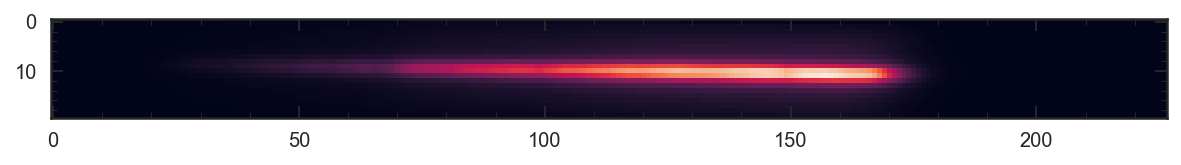

In [36]:
co.beam.compute_model(spectrum_1d=[mwv * (1 + 1.249), mfl])

## plot the spectra
plt.figure(figsize=[10,5])
plt.imshow(co.beam.model)

## Extract the model (error array here is meaningless)

In [31]:
w, f, e = co.beam.optimal_extract(co.beam.model, bin=0)

In [32]:
## interpolate spectra to match galaxy spectra
ifl = interp1d(w,f/ffl)(wv)

In [15]:
## function to scale model
def Scale_model(D, sig, M):
    return np.sum(((D * M) / sig ** 2)) / np.sum((M ** 2 / sig ** 2))

In [34]:
##Scale model
C = Scale_model(fl, er,ifl)

(0, 4e-18)

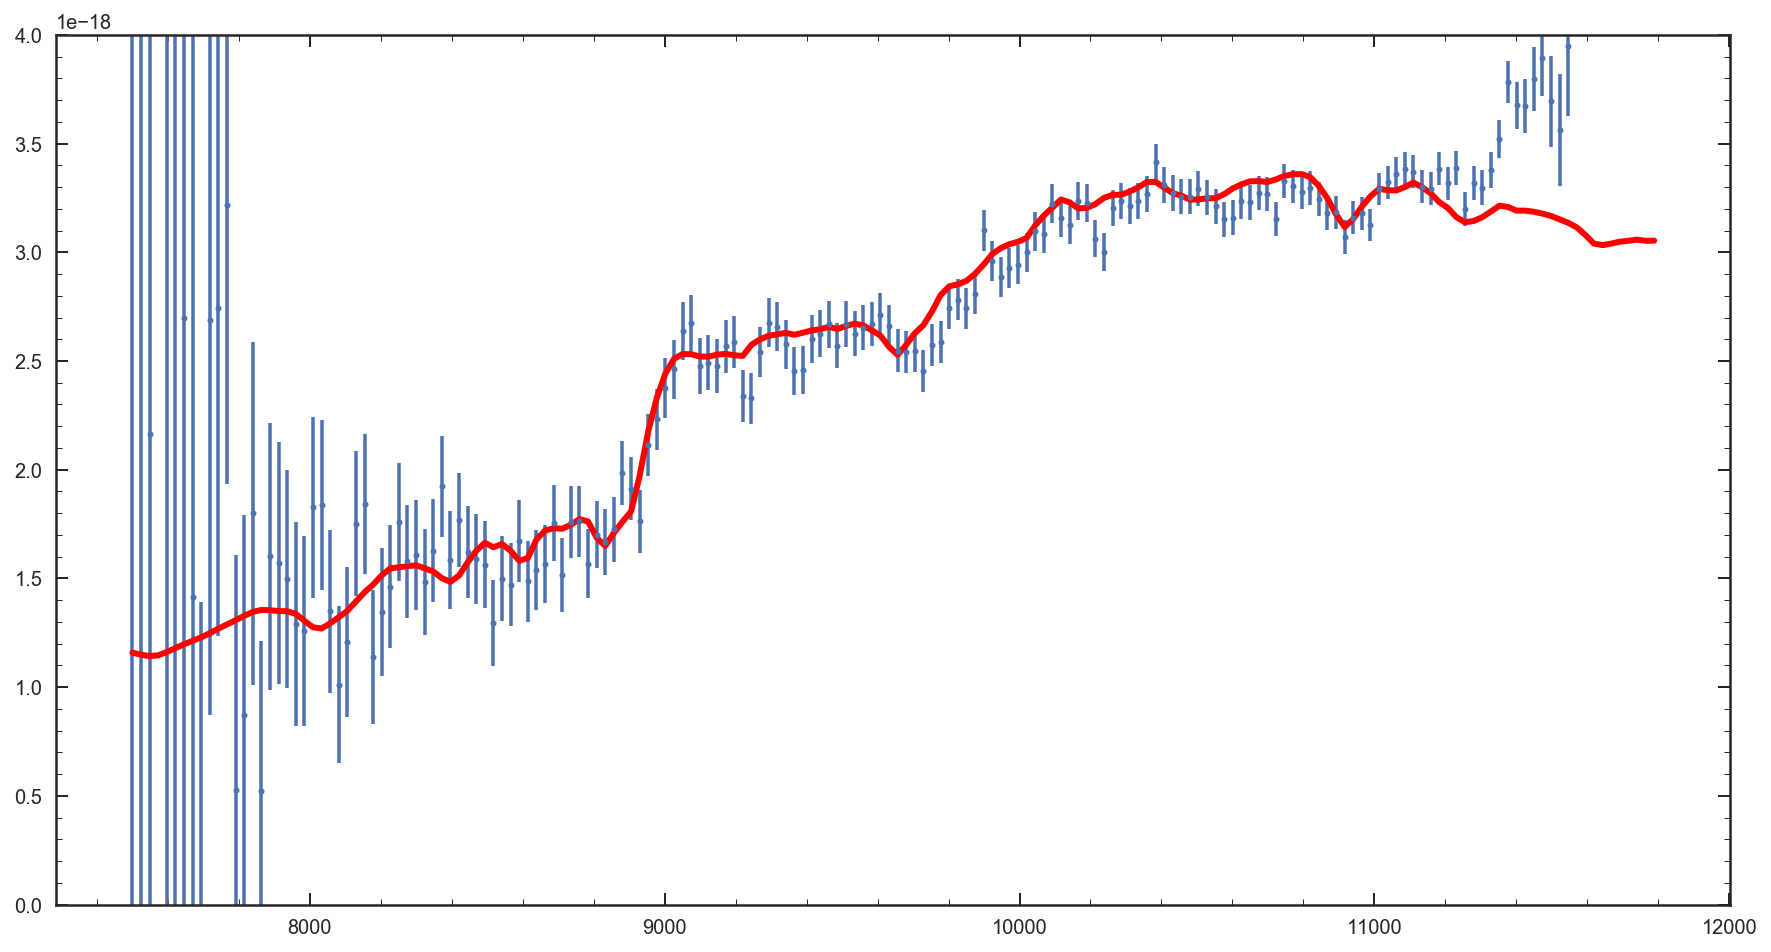

In [35]:
plt.figure(figsize=[15,8])

plt.errorbar(wv, fl, er, linestyle='None', marker='o', markersize=3)
plt.plot(wv, C*ifl, 'r', linewidth=3)
plt.ylim(0,0.4E-17)

In [23]:
class Gen_spec(object):
    def __init__(self, beam, redshift, spec_file, minwv = 7800, maxwv = 11200):
        self.beam = model.BeamCutout(fits_file = beam)
        self.redshift = redshift
        self.gal_wv, self.gal_fl, self.gal_er = np.load(spec_file)
        
        """ 


        """

        IDX = [U for U in range(len(self.gal_wv)) if minwv <= self.gal_wv[U] <= maxwv]

        self.gal_wv_rf = self.gal_wv[IDX] / (1 + self.redshift)
        self.gal_wv = self.gal_wv[IDX]
        self.gal_fl = self.gal_fl[IDX]
        self.gal_er = self.gal_er[IDX]

        ## Get sensitivity function
        flat = self.beam.flat_flam.reshape(self.beam.beam.sh_beam)
        fwv, ffl, e = self.beam.beam.optimal_extract(flat, bin=0)
        
        self.filt = interp1d(fwv, ffl)(self.gal_wv)
        
    def Sim_spec(self, model_file, model_redshift = 0, dust = 0):
        model_wv, model_fl = np.load(model_file)
        
        if model_redshift ==0:
            model_redshift = self.redshift 
        
        ## Compute the models
        self.beam.compute_model(spectrum_1d=[model_wv*(1+model_redshift),model_fl])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(self.beam.model , bin=0)

        ifl = interp1d(w, f)(self.gal_wv)
        
        C = Scale_model(self.gal_fl, self.gal_er, ifl / self.filt)

        self.fl = C * ifl / self.filt

In [21]:
beams = glob('beams/o*')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt

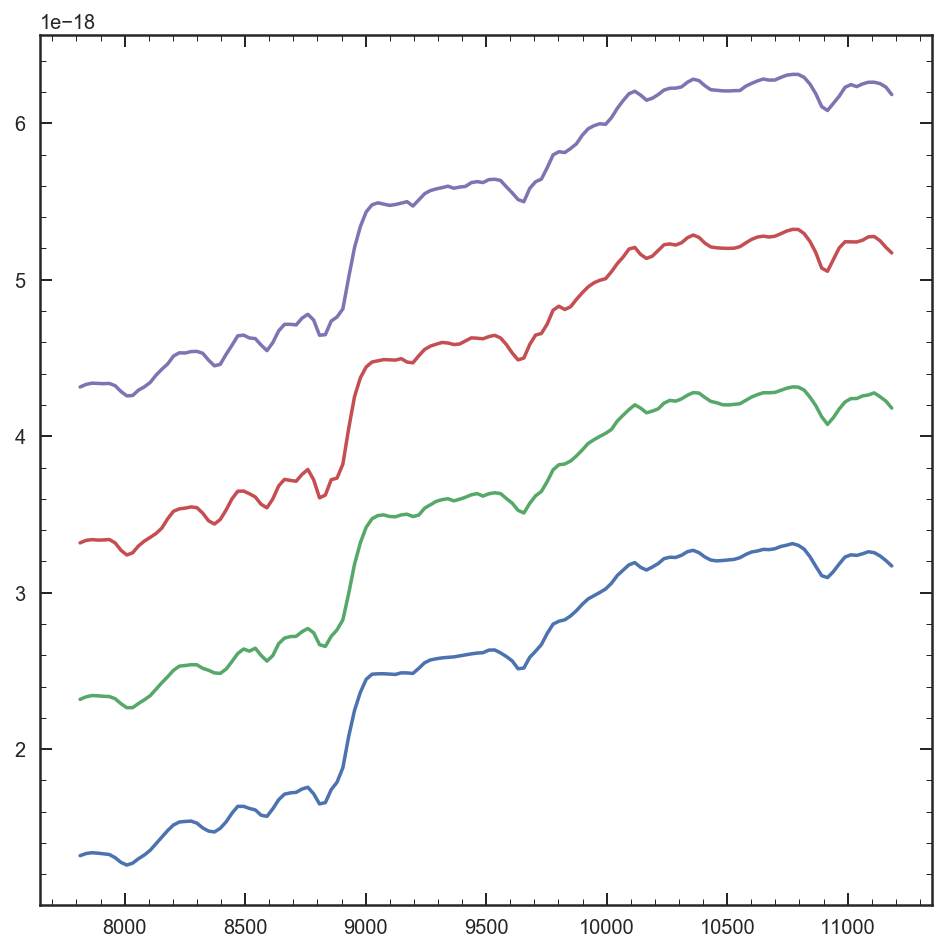

In [24]:
plt.figure(figsize=[8,8])

for i in range(len(beams)):
    sp = Gen_spec(beams[i], 1.248, 'galaxy_spec.npy')
    sp.Sim_spec('model_spec/m0.019_a2.5_dt8.0_spec.npy')
    
    plt.plot(sp.gal_wv, sp.fl+(i*0.1E-17))

## Forward modeling with MultiBeam

In [4]:
from grizli import multifit

In [20]:
## Read in model
mwv, mfl = np.load('model_spec/m0.019_a2.5_dt8.0_spec.npy')

## Read in beam information
mb = multifit.MultiBeam('beams/gnd_21156.beams.fits')

## Create model
spec = mb.get_flat_model(spectrum_1d = [mwv*2.25,mfl])

## Extract model and flat
sp = mb.optimal_extract(spec)
flat = mb.optimal_extract(mb.flat_flam[mb.fit_mask])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 /Users/Vince.ec/Clear_data/n_flt_files/icat21cfq_flt.fits G102
2 /Users/Vince.ec/Clear_data/n_flt_files/icat21coq_flt.fits G102
3 /Users/Vince.ec/Clear_data/n_flt_files/icat21dgq_flt.fits G102
4 /Users/Vince.ec/Clear_data/n_flt_files/icat21dlq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5 /Users/Vince.ec/Clear_data/n_flt_files/icat25hcq_flt.fits G102
6 /Users/Vince.ec/Clear_data/n_flt_files/icat25hiq_flt.fits G102
7 /Users/Vince.ec/Clear_data/n_flt_files/icat25icq_flt.fits G102
8 /Users/Vince.ec/Clear_data/n_flt_files/icat25iiq_flt.fits G102
9 /Users/Vince.ec/Clear_data/n_flt_files/icxt51jvq_flt.fits G102
10 /Users/Vince.ec/Clear_data/n_flt_files/icxt51jwq_flt.fits G102
11 /Users/Vince.ec/Clear_data/n_flt_files/icxt51jzq_flt.fits G102
12 /Users/Vince.ec/Clear_data/n_flt_files/icxt51k1q_flt.fits G102
13 /Users/Vince.ec/Clear_data/n_flt_files/icxt52i0q_flt.fits G102
14 /Users/Vince.ec/Clear_data/n_flt_files/icxt52i1q_flt.fits G102
15 /Users/Vince.ec/Clear_data/n_flt_files/icxt52i4q_flt.fits G102
16 /Users/Vince.ec/Clear_data/n_flt_files/icxt52i6q_flt.fits G102
17 /Users/Vince.ec/Clear_data/n_flt_files/icxt53i9q_flt.fits G102
18 /Users/Vince.ec/Clear_data/n_flt_files/icxt53iaq_flt.fits G102
19 /Users/Vince.ec/Clear_data/n_flt_files/icxt53idq_flt.fits G102
20 /Users/Vince

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1200: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1328: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1333: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:2948: FutureWarning: `rcond` parameter will change to the default of

In [14]:
## set model
mfl = sp['G102']['flux']/flat['G102']['flux']
mwv = sp['G102']['wave'][mfl**2 > 0]
mfl = mfl[mfl**2 > 0]

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [15]:
## Scale model
IDX = [U for U in range(len(wv)) if mwv[0] < wv[U] < mwv[-1]]
C = Scale_model(fl[IDX],er[IDX],interp1d(mwv,mfl)(wv[IDX]))

(0, 4e-18)

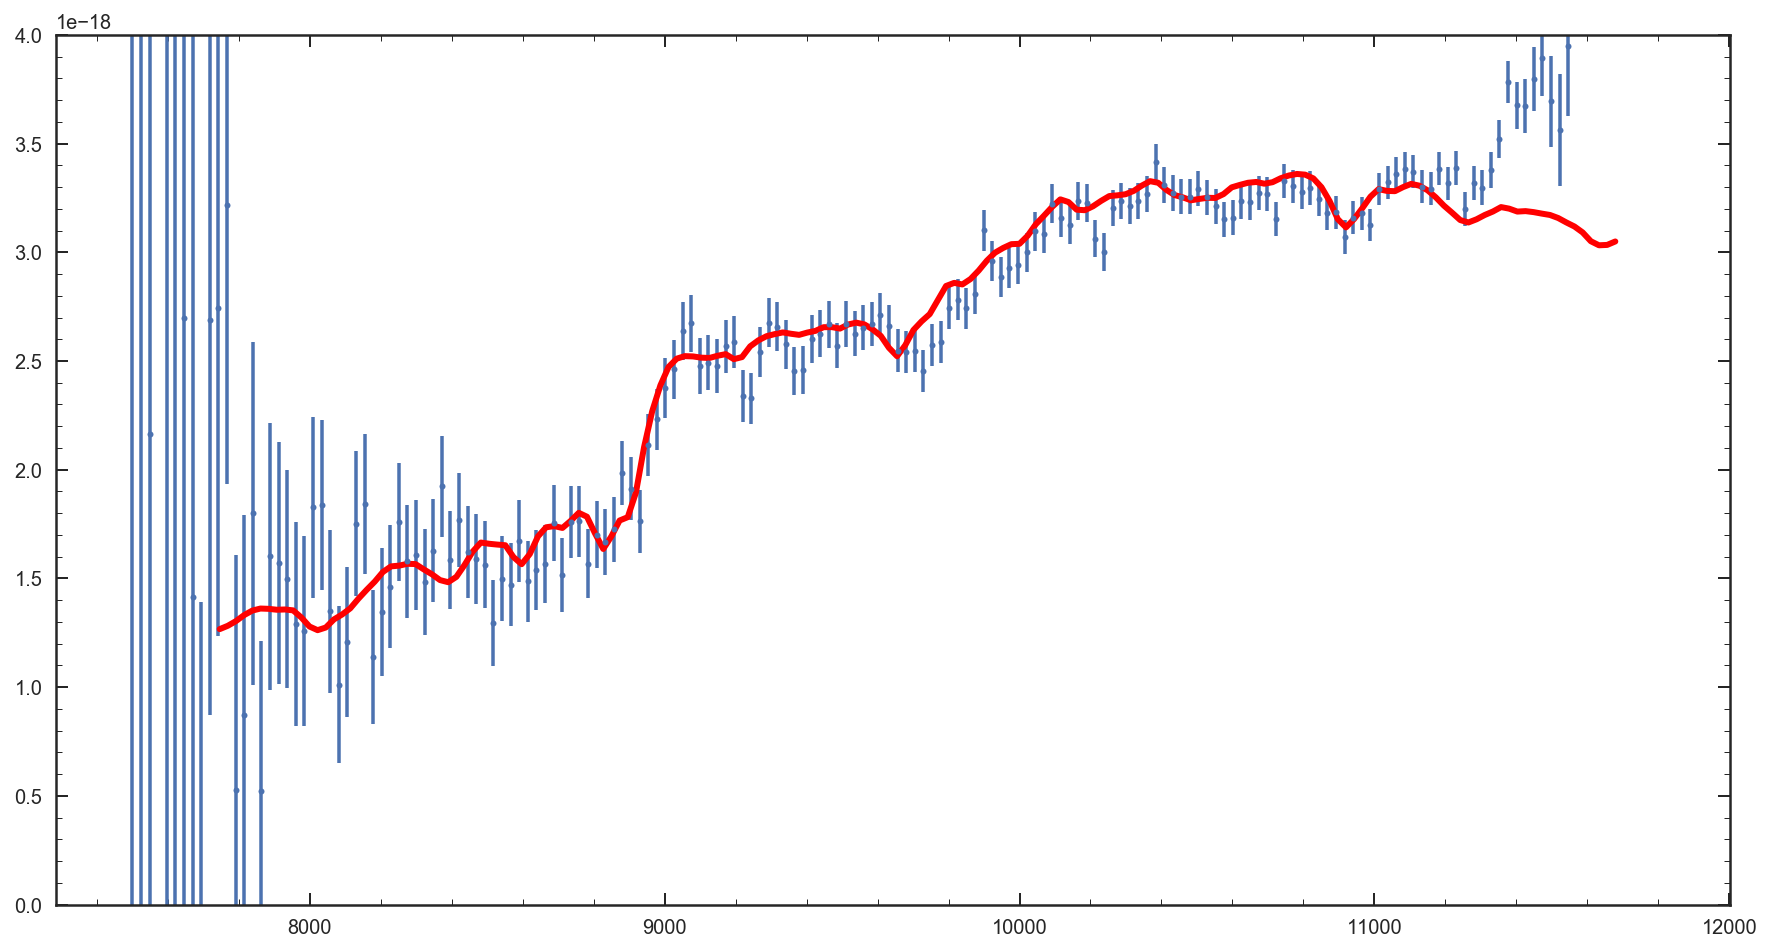

In [17]:
plt.figure(figsize=[15,8])
plt.errorbar(wv, fl, er, linestyle='None', marker='o', markersize=3)
plt.plot(mwv,C*mfl, 'r', linewidth=3)
plt.ylim(0,0.4E-17)

In [12]:
class Gen_MB_spec(object):
    def __init__(self, beams, redshift, spec_file, minwv = 7800, maxwv = 11200):
        self.mb = multifit.MultiBeam(beams)
        self.redshift = redshift
        self.gal_wv, self.gal_fl, self.gal_er = np.load(spec_file)
        
        """ 


        """

        IDX = [U for U in range(len(self.gal_wv)) if minwv <= self.gal_wv[U] <= maxwv]

        self.gal_wv_rf = self.gal_wv[IDX] / (1 + self.redshift)
        self.gal_wv = self.gal_wv[IDX]
        self.gal_fl = self.gal_fl[IDX]
        self.gal_er = self.gal_er[IDX]

        ## Get sensitivity function
        flat = self.mb.optimal_extract(self.mb.flat_flam[self.mb.fit_mask])
        
        self.filt = interp1d(flat['G102']['wave'], flat['G102']['flux'])(self.gal_wv)
        
    def Sim_spec(self, model_file, model_redshift = 0, dust = 0):
        mwv, mfl = np.load(model_file)
        
        if model_redshift ==0:
            model_redshift = self.redshift 
        
        ## Create model
        spec = self.mb.get_flat_model(spectrum_1d = [mwv *(1 + model_redshift), mfl])

        ## Extract model and flat
        sp = self.mb.optimal_extract(spec)
        
        ifl = interp1d(sp['G102']['wave'], sp['G102']['flux'])(self.gal_wv)
        
        C = Scale_model(self.gal_fl, self.gal_er, ifl / self.filt)

        self.fl = C * ifl / self.filt

In [13]:
sp = Gen_MB_spec('beams/gnd_21156.beams.fits', 1.249, 'galaxy_spec.npy')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 /Users/Vince.ec/Clear_data/n_flt_files/icat21cfq_flt.fits G102
2 /Users/Vince.ec/Clear_data/n_flt_files/icat21coq_flt.fits G102
3 /Users/Vince.ec/Clear_data/n_flt_files/icat21dgq_flt.fits G102
4 /Users/Vince.ec/Clear_data/n_flt_files/icat21dlq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5 /Users/Vince.ec/Clear_data/n_flt_files/icat25hcq_flt.fits G102
6 /Users/Vince.ec/Clear_data/n_flt_files/icat25hiq_flt.fits G102
7 /Users/Vince.ec/Clear_data/n_flt_files/icat25icq_flt.fits G102
8 /Users/Vince.ec/Clear_data/n_flt_files/icat25iiq_flt.fits G102
9 /Users/Vince.ec/Clear_data/n_flt_files/icxt51jvq_flt.fits G102
10 /Users/Vince.ec/Clear_data/n_flt_files/icxt51jwq_flt.fits G102
11 /Users/Vince.ec/Clear_data/n_flt_files/icxt51jzq_flt.fits G102
12 /Users/Vince.ec/Clear_data/n_flt_files/icxt51k1q_flt.fits G102
13 /Users/Vince.ec/Clear_data/n_flt_files/icxt52i0q_flt.fits G102
14 /Users/Vince.ec/Clear_data/n_flt_files/icxt52i1q_flt.fits G102
15 /Users/Vince.ec/Clear_data/n_flt_files/icxt52i4q_flt.fits G102
16 /Users/Vince.ec/Clear_data/n_flt_files/icxt52i6q_flt.fits G102
17 /Users/Vince.ec/Clear_data/n_flt_files/icxt53i9q_flt.fits G102
18 /Users/Vince.ec/Clear_data/n_flt_files/icxt53iaq_flt.fits G102
19 /Users/Vince.ec/Clear_data/n_flt_files/icxt53idq_flt.fits G102
20 /Users/Vince

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1200: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1328: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1333: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:2948: FutureWarning: `rcond` parameter will change to the default of

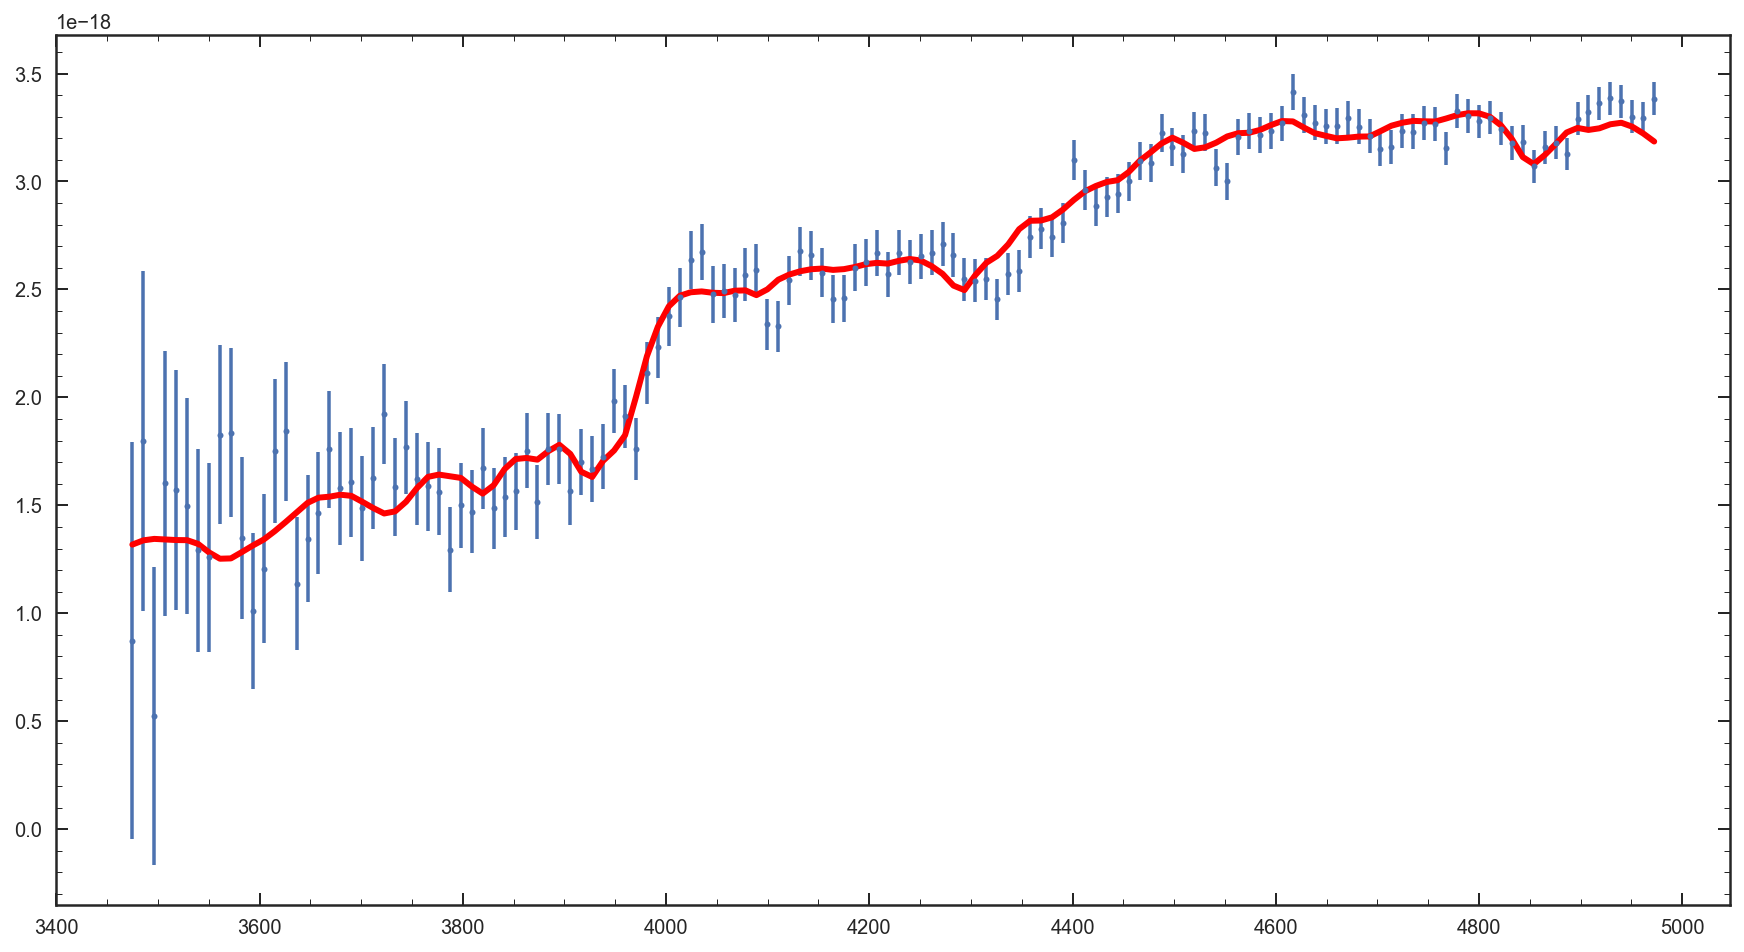

In [19]:
sp.Sim_spec('model_spec/m0.019_a2.5_dt8.0_spec.npy')

plt.figure(figsize=[15,8])
plt.errorbar(sp.gal_wv_rf, sp.gal_fl, sp.gal_er, linestyle='None', marker='o', markersize=3)
plt.plot(sp.gal_wv_rf,sp.fl, 'r', linewidth=3)